# Unet on Carvana Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import os
import PIL
from PIL import Image



In [2]:
PATH = '/home/juangomez/Desktop/ML/Cursos/Pepe Cantoral/datasets/carvana/'
TRAIN_PATH = os.path.join(PATH, 'train')
TRAIN_MASK_PATH = os.path.join(PATH, 'train_masks')
TEST_PATH = os.path.join(PATH, 'test')


# Use GPU

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
os.listdir(None)

['00-NN-From-Scratch.ipynb',
 '30-CNN.ipynb',
 '.git',
 '12-Multiple-Optimizer.ipynb',
 '.ipynb_checkpoints',
 '50-Unet.ipynb',
 '20-CIFAR-10.ipynb',
 'datasets',
 '.gitignore',
 '21-Transfer-Learning-ResNET.ipynb',
 '.idea',
 '10-MNIST.ipynb',
 '21-modelTransferLearning.pth',
 'models',
 'README.md',
 '11-Multiple-Learning-Rate.ipynb',
 '31-CNN-OOP-Batch-Normalization.ipynb',
 '40-Superconvergence-Resnet-56.ipynb']

# Datasets and Dataloader

In [6]:
class Car_Dataset(Dataset):
  def __init__(self, path_images, path_mask, img_transforms, mask_transforms):
    """
    data - train data path
    mask - tran mask path
    """
    self.path_images = path_images
    self.path_mask = path_mask

    self.img_transforms = img_transforms
    self.mask_transforms= mask_transforms

    self.image_names = sorted(os.listdir(path_images))
    self.mask_names = sorted(os.listdir(path_mask))

  def __len__(self):
    assert len(self.image_names) == len(self.mask_names)
    return len(self.image_names)

  def __getitem__(self, idx):
    image_path = os.path.join(self.path_images, self.image_names[idx])
    mask_path = os.path.join(self.path_mask, self.mask_names[idx])

    image = Image.open(image_path)
    mask = Image.open(mask_path)

    image = self.img_transforms(image)
    mask = self.mask_transforms(mask)

    mask_max = mask.max()
    mask = mask / mask_max

    return image, mask


## Transformations

In [7]:
transform_data = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

## Dataloaders

In [8]:
full_dataset = Car_Dataset(TRAIN_PATH, TRAIN_MASK_PATH, transform_data, transform_data)
BATCH_SIZE = 32
TRAIN_SIZE = int(0.8 * len(full_dataset))
VAL_SIZE = len(full_dataset) - TRAIN_SIZE


train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])


train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=True)


In [9]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)
del imgs, masks

torch.Size([32, 3, 224, 224]) torch.Size([32, 1, 224, 224])


# See the data

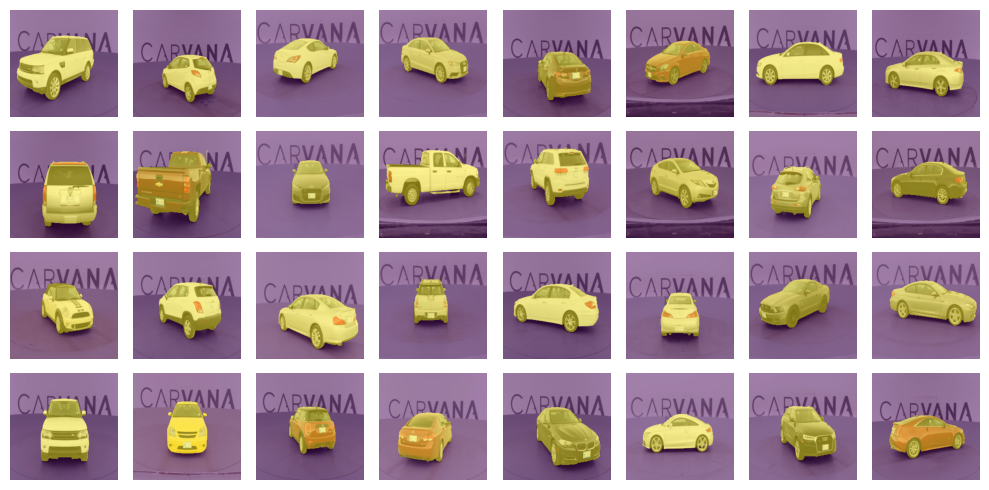

In [10]:

imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
  plt.figure(figsize=(10, 5))
  for i in range(BATCH_SIZE):
    plt.subplot(4, 8, i + 1)
    # permute before converting to numpy
    img = imgs[i, ...].permute(1, 2, 0).numpy()
    mask = masks[i, ...].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
  plt.tight_layout()
  plt.show()
  del img, mask

plot_mini_batch(imgs, masks)
del imgs, masks

## Find Learning rate

In [11]:

def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model.to(device=device)
    model.train()
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)

        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

        del scores, cost, x, y, preds

    return log_lrs, losses


## Accuracy

In [12]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

## Train loop

In [13]:
def train(model, optimizer, scheduler=None, epochs=100):
  model = model.to(device)
  for epoch in range(epochs):
    train_correct_num = 0
    train_total = 0
    train_cost_acum = 0.0
    model.train()
    for mb, (x, y) in enumerate(train_loader):

      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long).squeeze(1)
      scores = model(x)
      cost = F.cross_entropy(input = scores, target = y)

      optimizer.zero_grad()
      cost.backward()
      optimizer.step()
      if scheduler: scheduler.step()

      #
      train_predictions = torch.argmax(scores, dim=1)
      #
      train_correct_num += (train_predictions == y).sum().item()
      # Number of
      train_total += torch.numel(train_predictions)
      #
      train_cost_acum += cost.item()
    val_cost, val_acc, dice, iou = accuracy(model, val_loader)
    train_acc = float(train_correct_num / train_total)
    train_cost = float(train_cost_acum )/ len(train_loader)

    print(f'epoch: {epoch}, train cost: {train_cost}, val cost: {val_cost}'
          f'train_acc: {train_acc}, val acc {val_acc}'
          f'dice: {dice}, iou={iou}')


In [14]:
len(train_loader)

128

# Unet model

In [15]:
class Conv_3_k(nn.Module):
  def __init__(self, channels_in, channels_out):
    super().__init__()
    self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, padding=1, stride=1)

  def forward(self, x):
    return self.conv1(x)


In [16]:
class DoubleConv(nn.Module):
  def __init__(self, channels_in, channels_out):
    super().__init__()
    self.double_conv = nn.Sequential(
        Conv_3_k(channels_in, channels_out),
        nn.BatchNorm2d(channels_out),
        nn.ReLU(),

        Conv_3_k(channels_out, channels_out),
        nn.BatchNorm2d(channels_out),
        nn.ReLU()
    )

  def forward(self, x):
    return self.double_conv(x)


In [17]:
class Down_Conv(nn.Module):
  def __init__(self, channels_in, channels_out):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.MaxPool2d(kernel_size = 2, stride= 2),
        DoubleConv(channels_in, channels_out)
    )

  def forward(self, x):
    return self.encoder(x)

In [18]:
class Up_Conv(nn.Module):
  def __init__(self, channels_in, channels_out):
    super().__init__()
    self.upsample = nn.Sequential(
        nn.Upsample(scale_factor = 2, mode= 'bicubic'),
        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
    )
    self.decoder = DoubleConv(channels_in, channels_out)

  def forward(self, x1, x2):
    x1 = self.upsample(x1)
    x = torch.cat([x2, x1], dim=1)
    return self.decoder(x)

In [19]:
class Unet(nn.Module):
  def __init__(self, channels_in, channels, num_classes):
    super().__init__()
    self.first_conv = DoubleConv(channels_in, channels) # Salida => 64, 224, 224
    self.down1 = Down_Conv(channels, channels * 2) # Salida => 128, 112, 112
    self.down2 = Down_Conv(channels *2, channels *4) # Salida => 256, 56, 56
    self.down3 = Down_Conv(channels * 4, channels * 8) # Salida => 512, 28, 28
    self.down4_middle = Down_Conv(channels * 8, channels * 16) # Salida => 1024, 14, 14

    self.up1 = Up_Conv(channels_in=channels*16, channels_out=channels*8) # Salida => 512, 28, 28
    self.up2 = Up_Conv(channels_in=channels*8, channels_out=channels*4) # Salida => 256, 56, 56
    self.up3 = Up_Conv(channels_in=channels*4, channels_out=channels*2) # Salida => 128, 112, 112
    self.up4 = Up_Conv(channels_in=channels*2, channels_out=channels) # Salida => 64, 224, 224
    self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

  def forward(self, x):
    x1 = self.first_conv(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)

    x5 = self.down4_middle(x4)

    x6 = self.up1(x5, x4)
    x7 = self.up2(x6, x3)
    x8 = self.up3(x7, x2)
    x9 = self.up4(x8, x1)
    return self.last_conv(x9)


## test Model

In [20]:
def test():
  x = torch.randn((3, 1, 224, 224))
  model = Unet(1, 64, 2)
  predictions = model(x)
  return predictions

preds = test()


In [21]:
print(preds.shape)

torch.Size([3, 2, 224, 224])


In [22]:
torch.manual_seed(42)
model = Unet(3, 4, 2)
optimizer_unet = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=1e-4)



In [23]:
lg_lr, losses = find_lr(model, optimizer_unet, start_val = 1e-6, end_val=10)

cost:0.7904, lr: 0.0000
cost:0.7979, lr: 0.0000
cost:0.7958, lr: 0.0000
cost:0.7933, lr: 0.0000
cost:0.7945, lr: 0.0000
cost:0.7987, lr: 0.0000
cost:0.7933, lr: 0.0000
cost:0.7990, lr: 0.0000
cost:0.7914, lr: 0.0000
cost:0.7979, lr: 0.0000
cost:0.7989, lr: 0.0000
cost:0.7920, lr: 0.0000
cost:0.8067, lr: 0.0000
cost:0.7957, lr: 0.0000
cost:0.7937, lr: 0.0000
cost:0.8004, lr: 0.0000
cost:0.7927, lr: 0.0000
cost:0.7934, lr: 0.0000
cost:0.7943, lr: 0.0000
cost:0.7855, lr: 0.0000
cost:0.7961, lr: 0.0000
cost:0.8017, lr: 0.0000
cost:0.7944, lr: 0.0000
cost:0.7964, lr: 0.0000
cost:0.7870, lr: 0.0000
cost:0.7966, lr: 0.0000
cost:0.7892, lr: 0.0000
cost:0.7943, lr: 0.0000
cost:0.7902, lr: 0.0000
cost:0.7993, lr: 0.0000
cost:0.7852, lr: 0.0000
cost:0.7882, lr: 0.0001
cost:0.7784, lr: 0.0001
cost:0.7738, lr: 0.0001
cost:0.7834, lr: 0.0001
cost:0.7843, lr: 0.0001
cost:0.7829, lr: 0.0001
cost:0.7801, lr: 0.0001
cost:0.7647, lr: 0.0001
cost:0.7685, lr: 0.0001
cost:0.7739, lr: 0.0002
cost:0.7655, lr:

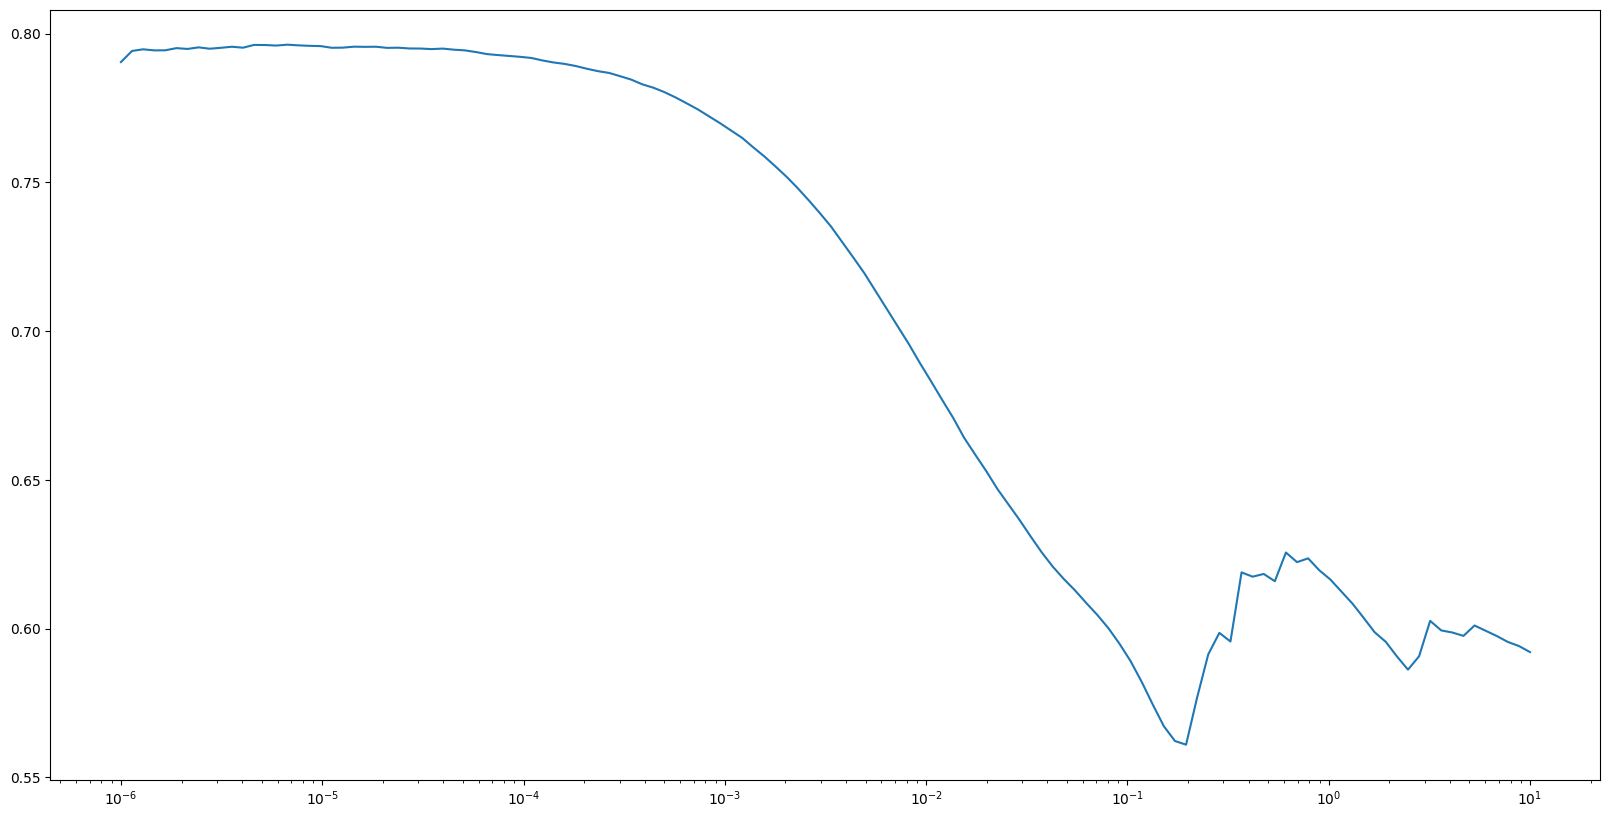

In [24]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

In [25]:
torch.manual_seed(42)
model = Unet(3, 4, 2)
epochs = 5
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [26]:
train(model, optimiser_unet, scheduler, epochs)

epoch: 0, train cost: 0.1649999016226502, val cost: 0.03597932413686067train_acc: 0.9186702218510254, val acc 0.9859235373606712dice: 0.9662597179412842, iou=0.9347218871116638
epoch: 1, train cost: 0.03058163150853943, val cost: 0.028071712877135724train_acc: 0.987841965813506, val acc 0.9884820363557997dice: 0.9726834297180176, iou=0.946819543838501
epoch: 2, train cost: 0.023190498715848662, val cost: 0.021149395091924816train_acc: 0.9908495902776037, val acc 0.9915219057600938dice: 0.9798948168754578, iou=0.9605821371078491
epoch: 3, train cost: 0.01981408214487601, val cost: 0.019329720351379365train_acc: 0.9921978028004814, val acc 0.9924441995609639dice: 0.9821152687072754, iou=0.9648590683937073
epoch: 4, train cost: 0.018436903708789032, val cost: 0.018244420207338408train_acc: 0.9927419023122148, val acc 0.9928506274808548dice: 0.983067512512207, iou=0.9666988849639893


torch.Size([32, 224, 224])


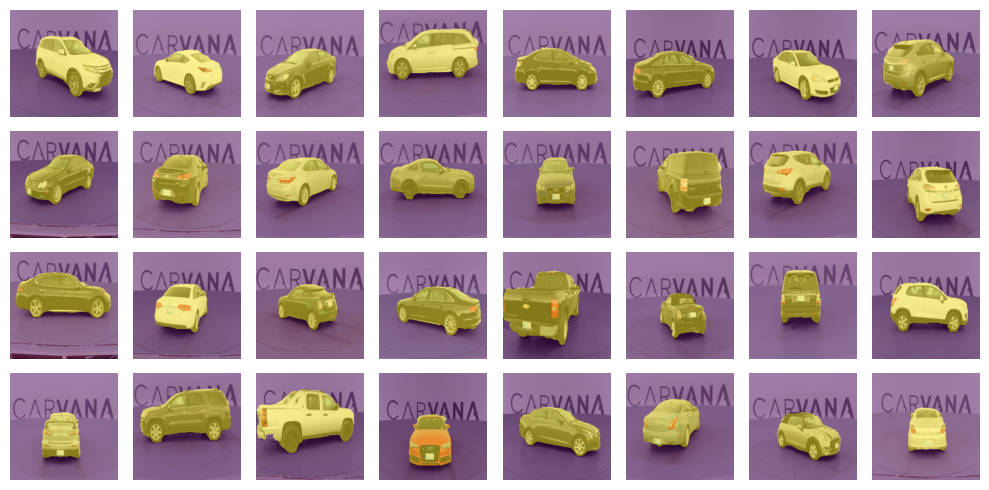

In [27]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))


# Test DAta

In [44]:
class Car_Dataset_Test(Dataset):
  def __init__(self, path_images, img_transforms):
    """
    data - train data path
    mask - tran mask path
    """
    self.path_images = path_images
    self.img_transforms = img_transforms
    self.image_names = sorted(os.listdir(path_images))

  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    image_path = os.path.join(self.path_images, self.image_names[idx])
    image = Image.open(image_path)
    image = self.img_transforms(image)
    return image


In [45]:
transform_data = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])
full_dataset_test = Car_Dataset_Test(TEST_PATH, transform_data)

In [46]:
BATCH_SIZE = 32
TEST_SIZE_1 = int(0.1 * len(full_dataset_test))
TEST_SIZE_2 = len(full_dataset_test) - TEST_SIZE_1

test_dataset , _ = random_split(full_dataset_test, [TEST_SIZE_1, TEST_SIZE_2])
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

torch.Size([32, 224, 224])


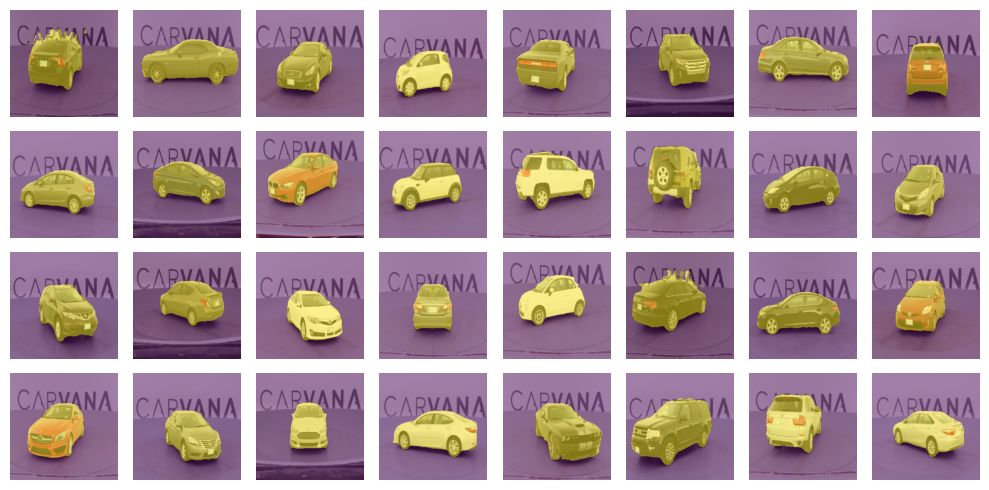

In [47]:
imgs_test= next(iter(test_loader))
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

## Save Model

In [28]:
torch.save(model.state_dict(), 'models/50-unet.pth')